In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.stats import norm as univariate_normal

In [2]:
num = 4
xs = np.repeat(np.arange(num), num)
ys = np.tile(np.arange(num), num)

states = np.array(list(zip(xs, ys)))
M = len(states)
state_ids = np.arange(M)


symbols = list(map(tuple, zip(xs, ys)))
symbol_ids = list(range(len(symbols)))
K = len(symbols)
M = len(states)

In [3]:
def true_transition_probability(x, y):
    norm = np.linalg.norm(x - y, ord=1)
    if norm == 1:
        return 1/2
    elif norm == 0:
        return 1
    else:
        return 0

def true_emission_probability(z, x):
    z_array = np.array(z)
    norm = np.linalg.norm(z_array - x, ord=1)
    if np.all(z_array == x):
        return 1
    else:
        return 1/norm

def true_initial_probability(x):
    return 1/states.shape[0]

In [4]:
true_P = np.zeros((M, M))
for i in state_ids:
    for j in state_ids:
        true_P[i, j] = true_transition_probability(states[i], states[j])
true_P = true_P / np.sum(true_P, axis=1)[:, np.newaxis]

In [5]:
true_b = np.zeros((K, M))
for i, symbol in enumerate(symbols):
    for j in state_ids:
        true_b[i, j] = true_emission_probability(symbol, states[j])
true_b = true_b / np.sum(true_b, axis=0)

In [6]:
def simulate_observations(T):
    truth = []
    observations = []
    
    state_id = random.choice(state_ids)
    state = states[state_id]
    truth.append(states[state_id])
    observation_id = np.random.choice(symbol_ids, p=true_b[:, state_id])
    observations.append(symbols[observation_id])
    for i in range(T):
        state_id = np.random.choice(state_ids, p=true_P[state_id, :])
        truth.append(states[state_id])
        observation_id = np.random.choice(symbol_ids, p=true_b[:, state_id])
        observations.append(symbols[observation_id])
    return truth, observations

In [7]:
true_path, observations = simulate_observations(20)

In [8]:
def transition_probability(x, y):
    norm = np.linalg.norm(x - y, ord=1)
    return univariate_normal.pdf(norm, loc=2, scale=1)

def emission_probability(z, x):
    norm = np.linalg.norm(z - x, ord=1)
    if np.all(z == x):
        return 1
    else:
        return 2/norm

def initial_probability(x):
    return 1/states.shape[0]

In [9]:
from hmm import DiscreteHiddenMarkovModel

hmm = DiscreteHiddenMarkovModel(
    transition_probability,
    emission_probability,
    initial_probability,
    states,
    symbols,
    enable_warnings=False
)

In [10]:
initial_P = hmm.P
initial_b = hmm.b

In [11]:
N = 10
sims = list(map(simulate_observations, [500]*N))
zs = list(map(lambda x: x[1], sims))

In [12]:
hmm.reestimation(zs, 2)

Running 2 iterations of Baum-Welch


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


array([-1384.43197101, -1383.03093035, -1382.75945368])

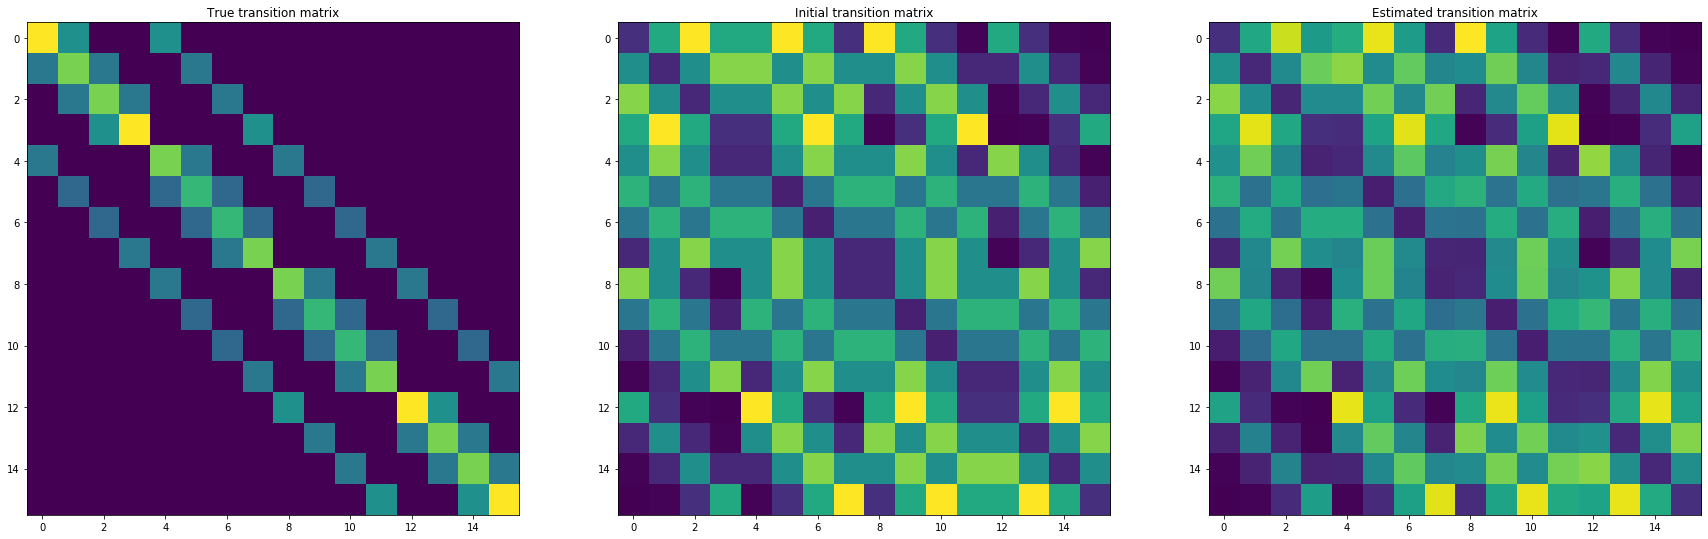

In [13]:
fig, axes = plt.subplots(1,3, figsize=(30, 10))
axes[1].imshow(initial_P)
axes[1].set_title("Initial transition matrix")
axes[0].imshow(true_P)
axes[0].set_title("True transition matrix")
axes[2].imshow(hmm.P)
axes[2].set_title("Estimated transition matrix");

In [14]:
print(f"Initial Frobenius norm: {np.linalg.norm(initial_P - true_P)}")
print(f"Frobenius norm after reestimation: {np.linalg.norm(hmm.P - true_P)}")

Initial Frobenius norm: 2.125548114333301
Frobenius norm after reestimation: 2.116477740260005


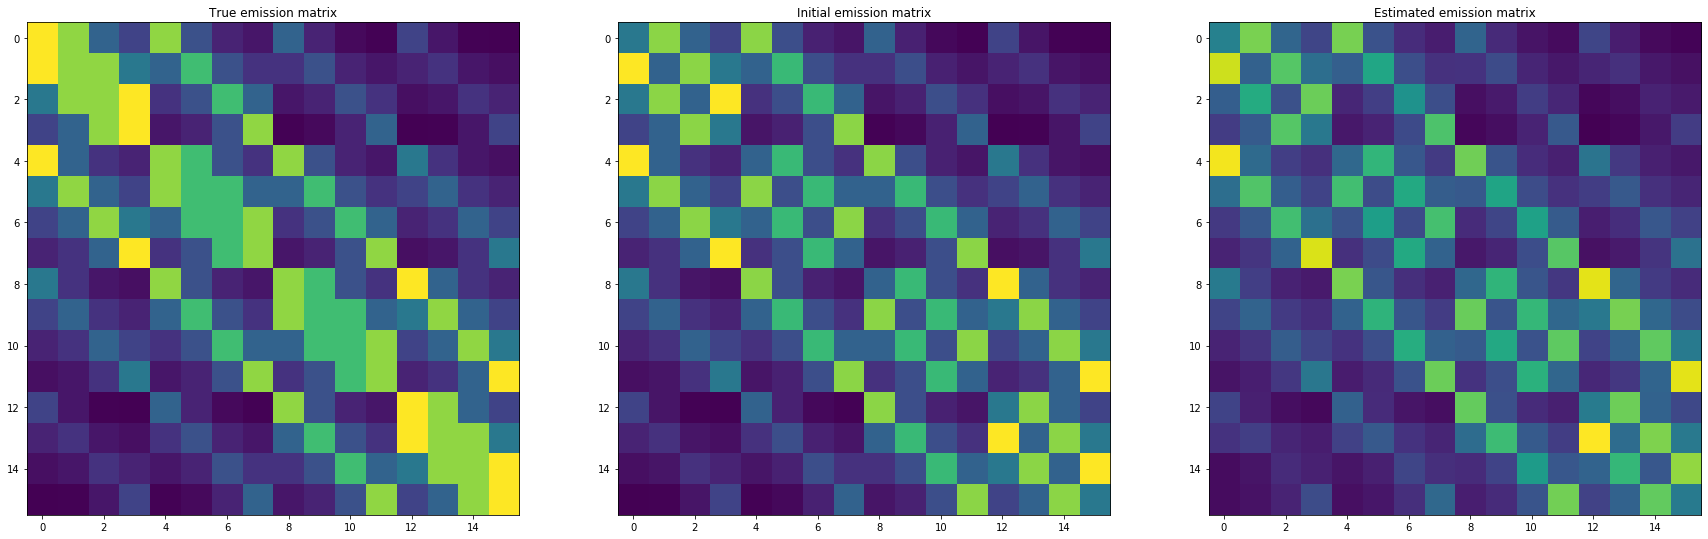

In [15]:
fig, axes = plt.subplots(1,3, figsize=(30, 10))
axes[1].imshow(initial_b)
axes[1].set_title("Initial emission matrix")
axes[0].imshow(true_b)
axes[0].set_title("True emission matrix")
axes[2].imshow(hmm.b)
axes[2].set_title("Estimated emission matrix");

In [16]:
print(f"Initial Frobenius norm: {np.linalg.norm(initial_b - true_b)}")
print(f"Frobenius norm after reestimation: {np.linalg.norm(hmm.b - true_b)}")

Initial Frobenius norm: 0.2378255307451114
Frobenius norm after reestimation: 0.24346975928192266
